In [1]:
from os.path import join, exists
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
import RQ_helper

Working directory: /home/wvdp/Documents/scratch
nptdms not available, skip for Argonne data.
No local midas libary installed


/home/wvdp/Documents/pycrp/pycrp/_event.py:34: UserWarning: No MIDAS reader found. See readme for how to install a python MIDAS interface.
  warnings.warn(


In [2]:
output_dir = "/project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/output/"

In [3]:
source_list = ['Background', 'AmBe', 'Co60', 'Ba133']
source_dict = {key:{} for key in source_list}

source_dict['Background']['data'] = joblib.load("Background_workingpoint_August.joblib")
source_dict['Ba133']['data'] = joblib.load('Ba133_August.joblib')
source_dict['Co60']['data'] = joblib.load('Co60_August.joblib')
source_dict['AmBe']['data'] = joblib.load("AmBe_August.joblib")

source_dict['Background']['rate'] = 0.98
source_dict['Co60']['rate'] = 2.65
source_dict['Ba133']['rate'] = 0.98
source_dict['AmBe']['rate'] = 1.97

source_dict['Background']['color'] = 'C1'
source_dict['Ba133']['color'] = 'C2'
source_dict['Co60']['color'] = 'C3'
source_dict['AmBe']['color'] = 'C4'

for k,v in source_dict.items():
    v['normalisation'] = v['rate']*24*3600/sum(v["data"]["mask_crystal"])
    print(k,v['normalisation'])
    exec(v['data']["config_str"])
    v['helper'] = RQ_helper.RQ_helper(v['data'],config, v['data']["series"], output_dir)

Background 1.3435095124002348
RQ helper is initialised
AmBe 1.624370132844709
RQ helper is initialised
Co60 1.895552538331622
RQ helper is initialised
Ba133 1.8029128694319052
RQ helper is initialised


10
Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 10/10 [00:01<00:00,  7.45it/s]


Raw data directory: /project/def-zqhong/RicochetData/MIT/MIT_Al_Summer2022/100kS_streaming/


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


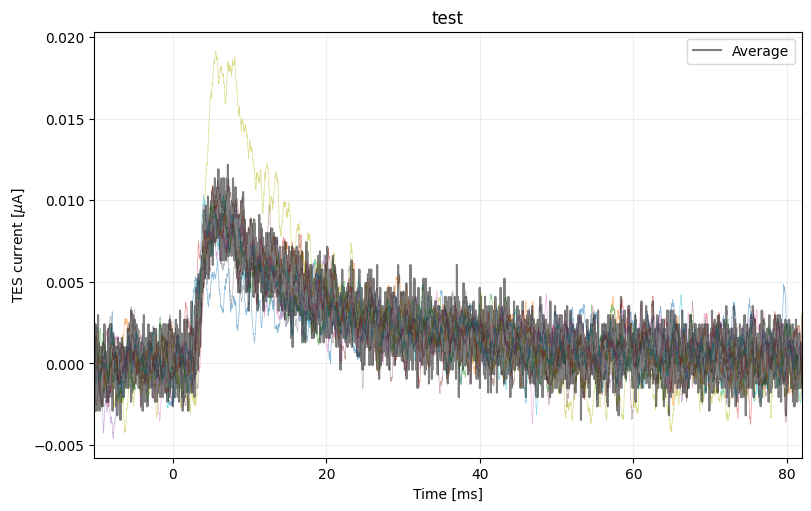

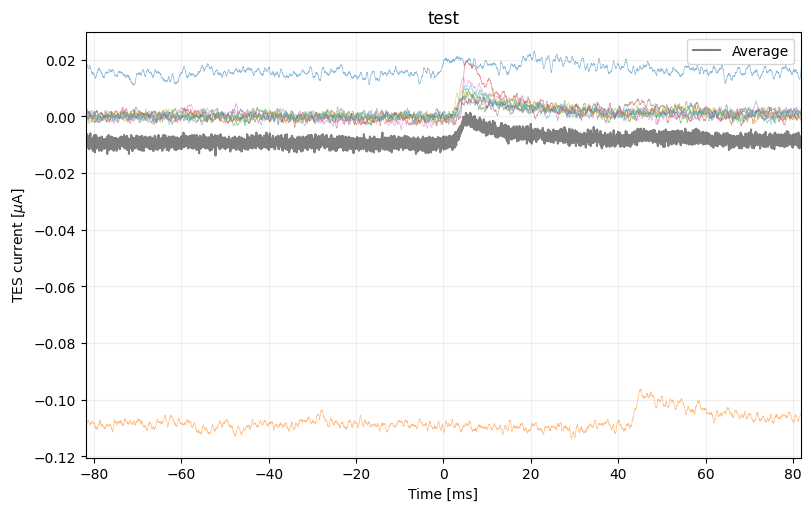

In [5]:
# AmBe Pulses: OFL_chi2_CH1 in [1.25, 1.3], Integral_CH1 in [15,20]
n_pulses = 10
mask = source_dict["AmBe"]['data']["mask_crystal"] &\
      (source_dict["AmBe"]['data']["OFL_chi2_CH1"]>1.25) & (source_dict["AmBe"]['data']["OFL_chi2_CH1"]<1.3) &\
      (source_dict["AmBe"]['data']["Integral_CH1"]>15) & (source_dict["AmBe"]['data']["Integral_CH1"]<20)
mask_sample = RQ_helper.sample_from_mask(mask,n_pulses)
print(sum(mask_sample))
times, traces_AmBe = source_dict["AmBe"]['helper'].plot_traces(mask_sample, "test", plot_data=0, nsmooth=100, plot_mean=0.5)

# Co60 Pulses: OFL_chi2_CH1 in [0.95, 1], Integral_CH1 in [15,20]
mask = source_dict["Co60"]['data']["mask_crystal"] &\
      (source_dict["Co60"]['data']["OFL_chi2_CH1"]>0.95) & (source_dict["Co60"]['data']["OFL_chi2_CH1"]<1) &\
      (source_dict["Co60"]['data']["Integral_CH1"]>15) & (source_dict["Co60"]['data']["Integral_CH1"]<20)
mask_sample = RQ_helper.sample_from_mask(mask,n_pulses)
times, traces_Co60 = source_dict["Co60"]['helper'].plot_traces(mask_sample, "test", plot_data=0, nsmooth=100, plot_mean=0.5, pre_trig=config.PRE_TRIG)

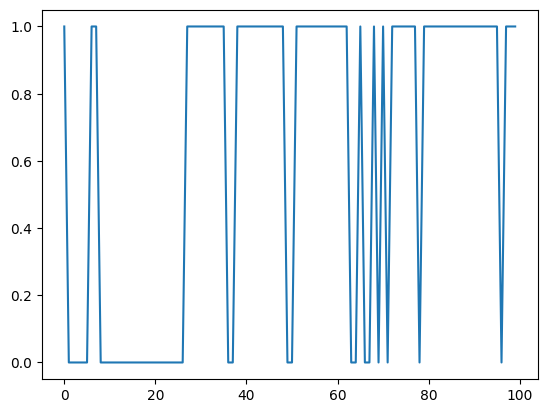

In [29]:
plt.plot((traces_Co60[0]>-0.005) & (traces_Co60[0]<0.005) )

In [30]:
traces_Co60_filtered = traces_Co60.T[ (traces_Co60[0]>-0.005) & (traces_Co60[0]<0.005) ].T

In [31]:
traces_Co60_filtered.shape

(9216, 64)

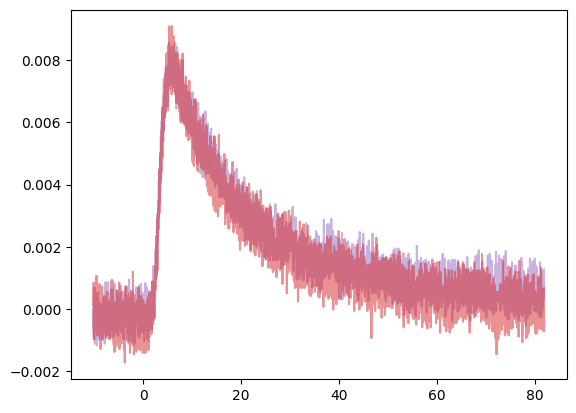

In [32]:
plt.plot(times, traces_AmBe.mean(axis=1), color='C4', alpha=0.5)
plt.plot(times, traces_Co60_filtered.mean(axis=1), color='C3', alpha=0.5)

In [2]:
def plot_var(field, mask, x_range, bins, log_flag=False, save_fig=False):
    fig, ax  = plt.subplots(figsize=(12,4), constrained_layout=True)
    fig_sub, ax_sub  = plt.subplots(figsize=(12,4), constrained_layout=True)

    for k,v in source_dict.items():
        data = v['data'][field][v['data'][mask]]
        weights = np.ones_like(data)*v['normalisation']
        vals, edges, _ = ax.hist(data, bins=bins, range = x_range, histtype="step", label=k, weights=weights, log=log_flag, color=v['color'], alpha=0.8)
        mids = (edges[1:]+edges[:-1])/2

        vals_plus = vals+np.sqrt(vals)
        vals_minus = vals-np.sqrt(vals)
        ax.fill_between(mids, vals_minus, vals_plus, alpha=0.2, step="mid", color=v['color'])
        
        # Background subtracted:
        data_bkgd = source_dict['Background']['data'][field][source_dict['Background']['data'][mask]]
        weights_bkgd = np.ones_like(data_bkgd)*source_dict['Background']['normalisation']
        vals_bkgd, edges = np.histogram(data_bkgd, bins=bins, range = x_range, weights=weights_bkgd)

        if k=="Background":
            ax_sub.axhline(0, linestyle='--', label="Background", alpha=0.5, color=v['color'])
        else:
            vals_sub = vals-vals_bkgd
            vals_sub_plus = vals_sub + np.sqrt(vals_bkgd+vals)
            vals_sub_minus = vals_sub - np.sqrt(vals_bkgd+vals)
            
            ax_sub.step(mids,vals_sub, where='mid', label=k, color=v['color'], alpha=0.8, lw=1)
            ax_sub.fill_between(mids, vals_sub_minus, vals_sub_plus, alpha=0.2, step="mid", color=v['color'])

    ax.grid(alpha=0.2)
    ax.legend()
    ax.set_xlabel(field)
    ax.set_ylabel("# Pulses/day/bin")
    ax.set_xlim(*x_range)

    ax_sub.grid(alpha=0.2)
    ax_sub.legend()
    ax_sub.set_xlabel(field)
    ax_sub.set_ylabel("# Pulses/day/bin [Background Subtracted]")
    ax_sub.set_xlim(*x_range)

    if save_fig:
        fig.savefig(join(output_dir, f"{field}_{mask}_hist.pdf"))
        fig_sub.savefig(join(output_dir, f"{field}_{mask}_hist_bkgd_sub.pdf"))

    return (fig,ax), (fig_sub,ax_sub)

((<Figure size 1200x400 with 1 Axes>,
  <AxesSubplot: xlabel='OFL_CH1', ylabel='# Pulses/day/bin'>),
 (<Figure size 1200x400 with 1 Axes>,
  <AxesSubplot: xlabel='OFL_CH1', ylabel='# Pulses/day/bin [Background Subtracted]'>))

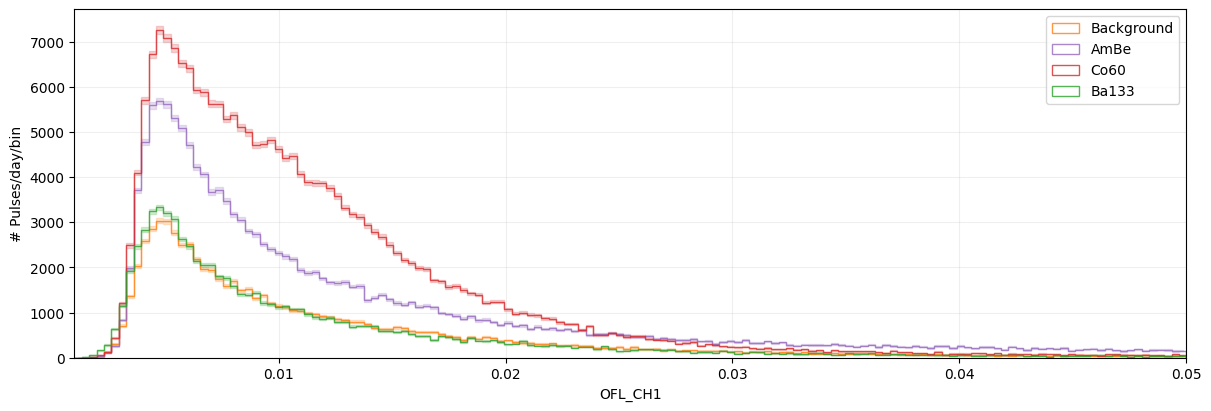

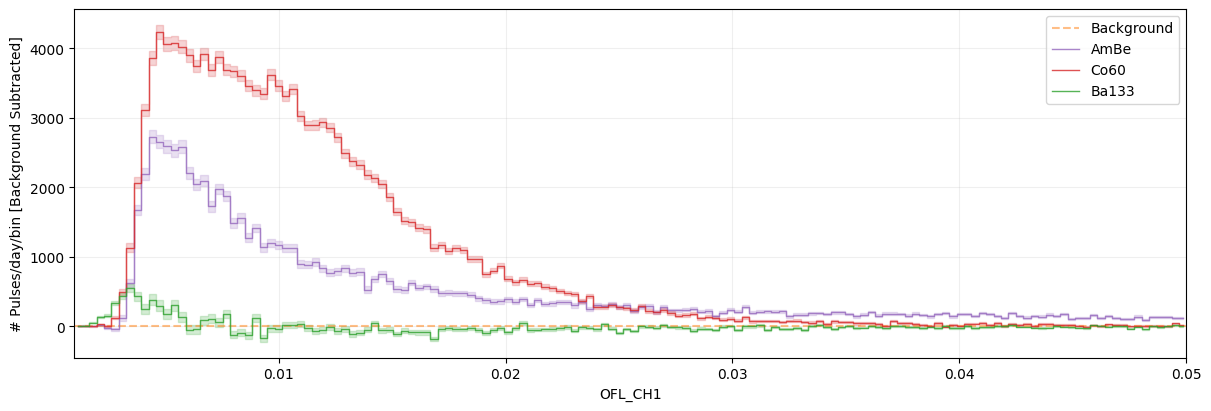

In [37]:
field = 'OFL_CH1'
mask = 'mask_crystal'
x_range = (0.001,0.05)
bins = 150
plot_var(field, mask, x_range, bins, log_flag=False)

((<Figure size 1200x400 with 1 Axes>,
  <AxesSubplot: xlabel='OFL_chi2_CH1', ylabel='# Pulses/day/bin'>),
 (<Figure size 1200x400 with 1 Axes>,
  <AxesSubplot: xlabel='OFL_chi2_CH1', ylabel='# Pulses/day/bin [Background Subtracted]'>))

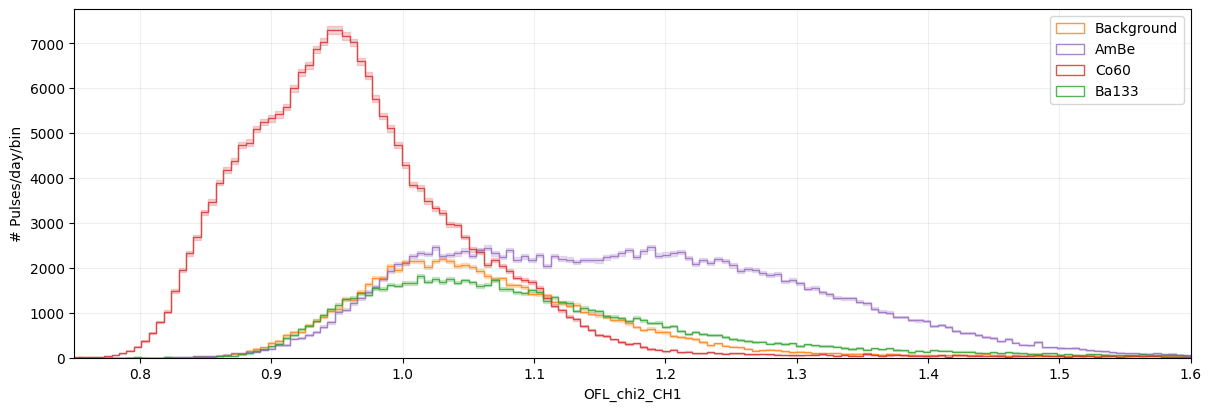

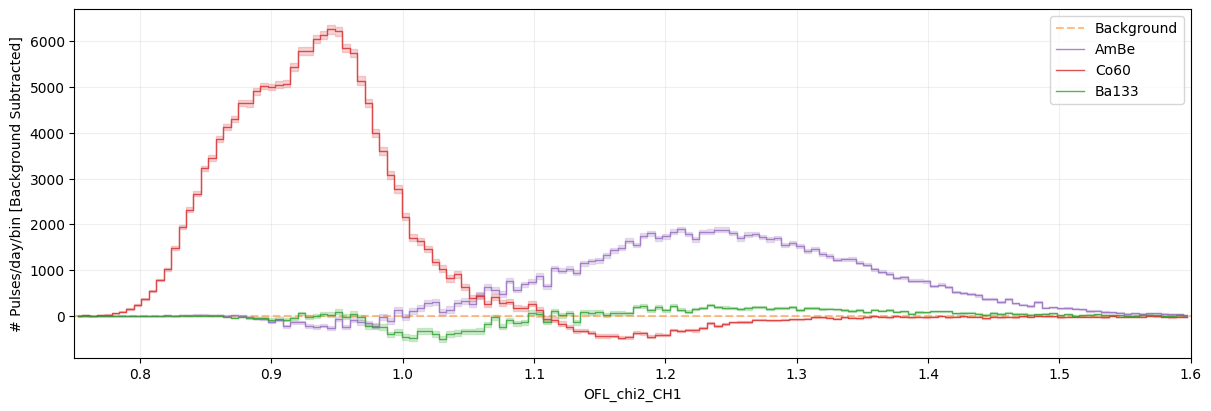

In [38]:
field = 'OFL_chi2_CH1'
mask = 'mask_crystal'
x_range = (0.75,1.6)
bins = 150
plot_var(field, mask, x_range, bins, log_flag=False)

(0.75, 1.6)

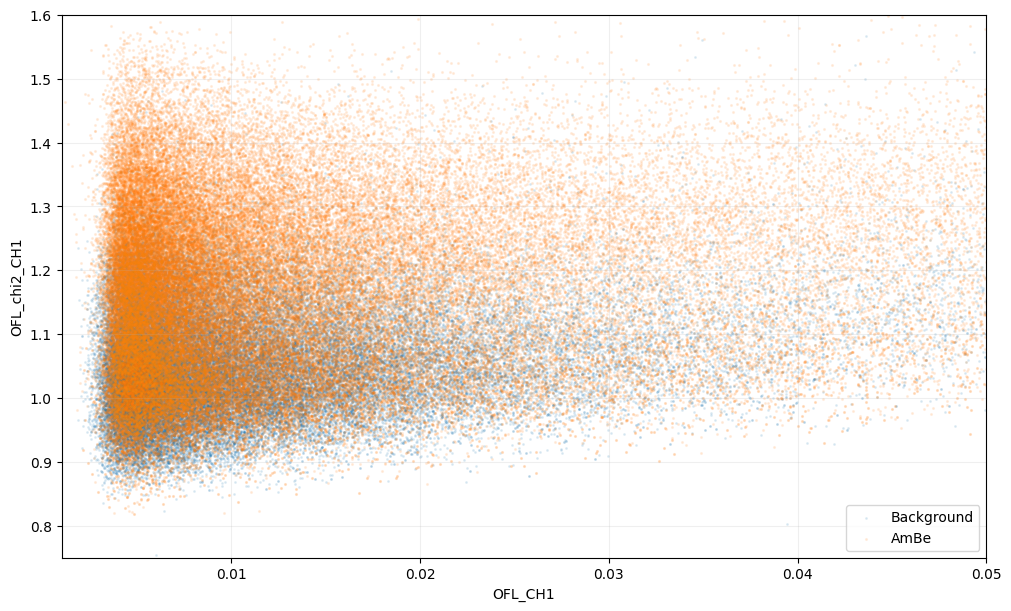

In [10]:
fig, ax  = plt.subplots(figsize=(10,6), constrained_layout=True)

field_x = 'OFL_CH1'
field_y = 'OFL_chi2_CH1'
x_range = (0.001,0.05)
y_range = (0.75,1.6)

select_samples = ['Background', 'AmBe']

for k,v in source_dict.items():
    if k in select_samples:
        data_x = v['data'][field_x][v['data'][mask]]
        data_y = v['data'][field_y][v['data'][mask]]
        ax.scatter(data_x, data_y, alpha=0.1, s=v['normalisation'],label=k)

ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel(field_x)
ax.set_ylabel(field_y)
ax.set_xlim(*x_range)
ax.set_ylim(*y_range)